# Multi-dimensional data analysis and visualization

In this notebook, we will walk through the basics of data analysis when working with multi-dimensional datasets.

### Learning objectives:
- What is multi-dimensional data, and why does it need to be treated differently?
- Basics of Xarray - a useful package for multi-dimensional data handling
- Plotting using Xarray
- An introduction to Dask and parallel computing

### Bonus objectives:
- How to access datasets stored on Pangeo Cloud

This tutorial is largely drawn from an online book: [An Introduction to Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html). This JupyterBook is a great resource, integrating code with topics in environmental science.

## Tabular data vs. multi-dimensional data

Tabular data can easily be written in terms of rows and columns, e.g:

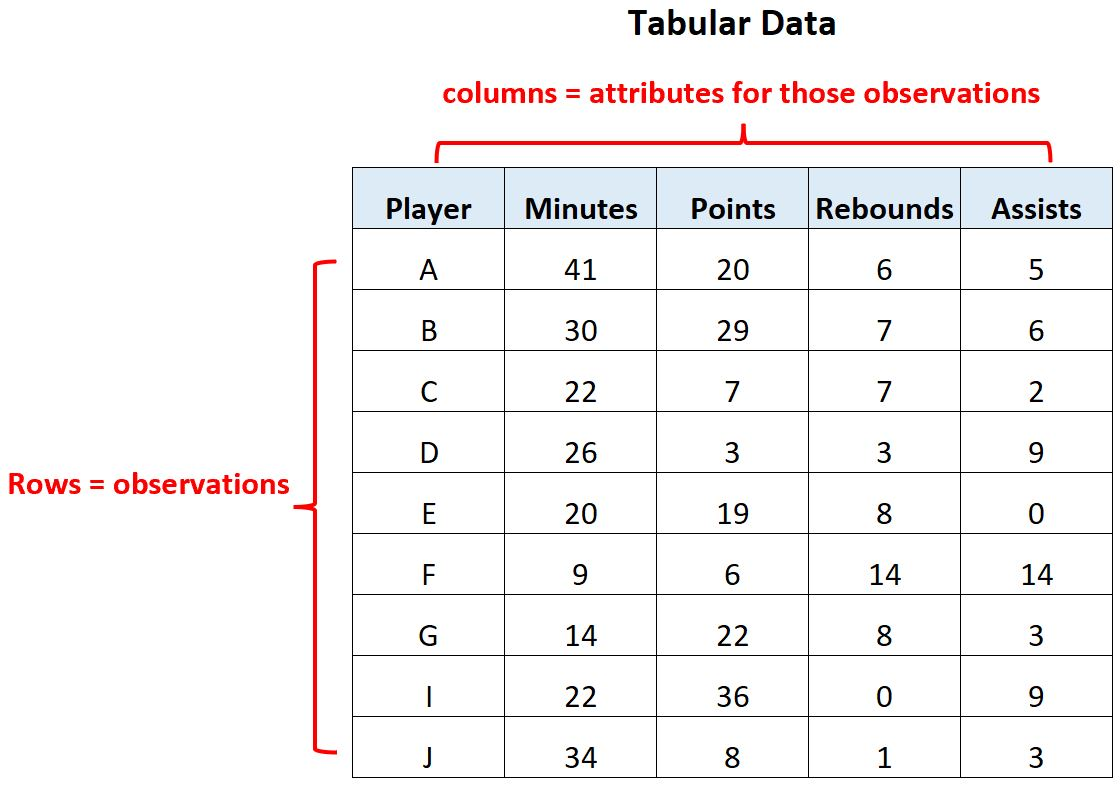

In earth science, the rows are often observations. For example, let's say you are measuring the air temperature and humidity in multiple geographical locations. Then each geographical location would be a row, and the temperature of the air would be one column, and humidity would be a second column.

But often in climate science, we have data that has multiple dimensions (sometimes called "N-dimensional data"). For example, we my represent the Earth's surface temperature as

$$
T(x,y,t),
$$

where $x$ is longitude, $y$ is latitude, and $t$ is time. Then we will need a representation such as:

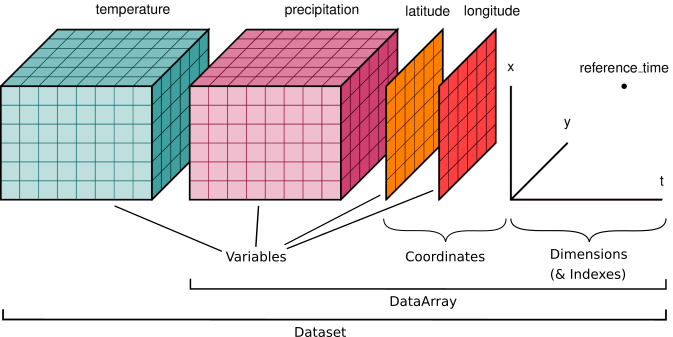

Note that we can also have multiple variables that depend on the same dimensions (e.g. precipitation: $P(x,y,t)$).

In Daniel's lab yesterday and Oladipo's lab during the pre-workshop, you saw the library `Pandas` in action to handle tabular data. This lab will instead use the library `Xarray`, which provides Pandas-style features for multi-dimensional data analysis.

# Load a dataset

This is a dataset from 41 years of the CESM (Community Earth System Model) ocean model ("POP": Parallel Ocean Program). This dataset is stored on the Cloud through the Pangeo Project, and we can load it directly into this notebook that is running on the Cloud too! 

When we say "load" here, we actually don't load the entire dataset into memory. Instead, we do what is called "lazy loading", where we load only the dataset metadata initially. In this way, we can examine the dataset (which variables, size of variables, names of dimensions, etc.) without having to worry about how large the dataset is. This is very handy when using large datasets (such as the CESM dataset we will use here which is a whopping 5.6  terabytes!), since the dataset is too large to fit into any computer's memory. 

But, often we are only interested in one variable (say, sea surface temperature) or a specific spatial region or time frame, and so we only need a small subset of the larger dataset. `xarray` and `dask` allow us to work with large datasets and only load in the portion of the data that we actually are interested in, making it possible to do data analysis on very large datasets.

We load in the (meta)data below using the library `intake`, which (among other features) provides a quick and standardized way to load data from a catalog. You can read more about `intake` [here](https://intake.readthedocs.io/en/latest/).

In [ ]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds  = cat["CESM_POP_hires_control"].to_dask()

# xarray

#### To view details of the dataset, simply type its name (we called it `ds` above)

In [ ]:
ds

#### So you can see that the data has a few things to note:

- the data is a `xarray.Dataset` type
- 8 dimensions of different sizes: nlat, nlon, time, ...
- 59 coordinates: time, along with many others
- 12 variables: SST, and many others
- a list of attributes (i.e. metadata about the dataset: full name of model run, time format, etc.)

The above output is actually interactive, so you can click on the arrows to the lft of the words (e.g. the arrow to the left of "Data variables" to view a list of variables stored in this dataset. You can also click on the icons on the right end of each line. So, if you want to know what the variable SST is, click the paper icon on the right and it will tell you that it is the "Surface Potential Temperature" in degrees Celsius ("degC").

The icon that looks like stacked cylinders immediately to the right of the paper icon is also clickable, and shows information about the size, shape, and type of data in that variable. Notice that it has two columns: one for the full variable array and one for single chunks of the DataArray. As you can see, the chunks are much smaller in size than the full array, and chunking up arrays into small, manageable sizes is one of the main ways we can reduce computations on large datasets into doable actions.

You can start to understand just how useful xarray, as it can load and display all different types of information about a dataset.

To access items within the dataset, we just type `ds.` followed by the aspect of the dataset we are interested in. The following few cells show a few examples.

See information about the variable 'SST':

In [ ]:
ds.SST

Notice that SST is an `xarray.DataArray`, as opposed to a `xarray.Dataset` like our `ds` above. In `xarray`, a Dataset is a collection of DataArrays. So typically, each variable and coordinate is a DataArray, and all together they make up a Dataset.

List information about the time dimension. This model uses `cftime` - a python library for denoting time - and uses a calendar without leap years. Hence the `cftime.DateTimeNoLeap` objects:

In [ ]:
ds.time

You can see that the first three timesteps start with the number 46. In this model, 46 is the starting model year, while the numbers following are the month and day, respectively. So this dataset starts on January 2nd, in the 46th year of the model run, and ends on January 1st, year 87 of the model. So this tells us that we have ~41 years of data, at daily output.

List all dimensions:

In [ ]:
ds.dims

There are quite a few dimensions in a global ocean model like this. Here, `nlat` and `nlon` are the number of points in the latitudinal and longitudinal directions (i.e. not the lat/lon values themselves).

One of the great features of xarray is that it is aware of the names of dimensions. So if, for instance, you'd like to grab the output from only the first day of the dataset, you can do so as follows:

In [ ]:
# Grab the SST output from the first day only 
ds.SST.isel(time=0)

Notice how we don't need to specify which axis number `time` is - we need only write 'time' and xarray knows which dimension that is. The `.isel()` functions selects the specified range (in the above case, the 0th index of `time`). We can also grab a larger range of values, e.g. by grabbing the first 10 days of SST:

In [ ]:
# Grab the SST output from the first day only 
ds.SST.isel(time=slice(0,10))

Xarray also allows for some simple data manipulation, such as taking the mean of a dataset. First we select the SST variable, and then we write out the function `.mean()` with the argument 'time' to take the time average.

In [ ]:
ds.SST.mean('time')

Great, so we just took the mean of a dataset in one line! What if we want to plot some data? Let's try to plot the first day of SST data. All you have to do is add `.plot()` to the end of the line!

In [ ]:
# Note: this may take several seconds
ds.SST.isel(time=0).plot()

You may have noticed that this sook several seconds. Until now, we hadn't actually *loaded* any of the data. We had just loaded metadata - enough for us to look at the data and understand it a bit better. But, to make a plot, we need to actually access the data, and so adding `.plot()` triggers a load of the data, but only what is needed to make the plot. Since we only plotted the first day, it was reasonably quick. 

Notice how `Xarray` labels our axes and colorbars for us! Let's compare this to using `pyplot` without `Xarray`.

First we need to import the package.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.pcolormesh(ds.SST.isel(time=0))

This looks noticeably different! No axes labels and a different colorbar! `Xarray` is super handy and can interpret the metadata to create nice labels on our figures. `Xarray` also uses a different default colorbar than `pyplot` - `Xarray` uses the `cmocean` (see [website here](https://matplotlib.org/cmocean/)) colorbar, and automatically interprets data that is both positive and negative with a diverging colorbar centered at 0.

### EXERCISE #1!

Replace the `Xarray` default title for the above plot with one that makes more sense: "Snapshot of sea surface temperature".


<details><summary>Hint 👇 </summary>
    Below the line that plots the data, you will need a line that starts with plt.title(), and then insert the title you want inside the function call (between the parentheses) with the quotation marks.
</details>


**Bonus:** increase the title fontsize to 24!

<details><summary>Bonus hint 👇 </summary>
    In the function call `plt.title()` you will need to add `fontsize=18` after the title name, separated by a comma. 
</details>

In [ ]:
# Write your answer here



<details>
    <summary>Answer 👇  </summary>
    
```python
ds.SST.isel(time=0).plot()
plt.title('Snapshot of sea surface temperature',fontsize=18)
```
</details>

### EXERCISE #2!

In one line, write the code to make a plot of the global sea surface height averaged over the first 5 days of the dataset `ds`. 


<details><summary>Hint 1 👇 </summary>
    Scroll back up to the printed output of `ds` and find the variable name for sea surface height.
</details>

<details><summary>Hint 2 👇 </summary>
    You will need to use the `.isel()` and `.mean()` commands with inputs to these functions (i.e. you will need to add text between the parentheses).
</details>

In [ ]:
# Write your answer here



<details>
    <summary>Answer 👇  </summary>
    
```python
ds.SSH_2.isel(time=slice(0,5)).mean('time').plot()
```
</details>

## Let's load in a different ocean dataset: CM2.6 

In [ ]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
ds_cm26  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()

In [ ]:
ds_cm26

### EXERCISE #3!

In one line, write the code to make a plot of the global sea surface temperature averaged over the first 5 days of the dataset `ds_cm26` and compare to the previous POP dataset which we called `ds`. 


<details><summary>Hint 1 👇 </summary>
    Scroll up to the printed output of `ds_cm26` in the previous cell and find the variable name for sea surface temperature.
</details>

<details><summary>Hint 2 👇 </summary>
    You will need to use the `.isel()` and `.mean()` commands as in Exercise #2.
</details>

In [ ]:
# Write your answer here



<details>
    <summary>Answer 👇  </summary>
    
```python
ds_cm26.surface_temp.isel(time=slice(0,5)).mean('time').plot()
```
</details>

#### Select lat/lon range

In addition to the `.isel()` command, there is also the `.sel()` command. While `.isel()` is a way to select based on the index number, `.sel()` can select based on the values of the coordinates or dimensions.

Let's use the `.sel()` command on the x and y values (i.e. longitude and latitude) to zoom in on the Gulf Stream. Note that `xt_ocean` and `yt_ocean` are the x and y dimensions and are in degrees East and North, respectively.

By looking at the plot we made in Exercise #3 to estimate the longitude and latitude values for the Gulf Stream.

In [ ]:
ds_cm26.surface_temp.isel(time=0).sel(xt_ocean=slice(-80,-20),yt_ocean=slice(25,50)).plot()

### EXERCISE #4!

Follow the same steps as above to zoom in on the Gulf of Guinea region. 


<details><summary>Hint 👇 </summary>
    Look at your plot from Exercise #3 to estimate the relevant longitude and latitude values.
</details>

In [ ]:
# Write your answer here



<details>
    <summary>Answer 👇  </summary>
    
```python
ds_cm26.surface_temp.isel(time=0).sel(xt_ocean=slice(-15,15),yt_ocean=slice(-2,15)).plot()
```
</details>

#### Groupby

`Xarray`'s `.grouby()` function can be used to group together relevant data points. For example, let's say we want to group our dataset together across months and compare the sea surface temperature between January and July.

First, we create a `GroupBy` object by month. We will be using the `time` dimension:

In [ ]:
ds_cm26.time

From here, we can use `Xarray`'s built-in "accessor" called `dt`. `dt` is based on its equivalent in `pandas` and includes many different time groupings: “year”, “month”, “day”, “hour”, “minute”, “second”, “dayofyear”, “week”, “dayofweek”, “weekday”, "season", and “quarter”. Here, let's use "month" as an example.

In [ ]:
ds_cm26_months = ds_cm26.surface_temp.groupby(ds_cm26.time.dt.month)
ds_cm26_months

We now have an object with 12 items for the 12 months of the year! Let's plot the January (index 1) month to see what it looks like. Note that we are grabbing only the first time point for speed here, but it would be commmon to average across all January time points, for example.

In [ ]:
ds_cm26_months[1].isel(time=0).plot()

Looks about as we would expect! Let's now subtract the first time element in January from the that of July.

In [ ]:
(ds_cm26_months[7].isel(time=0) - ds_cm26_months[1].isel(time=0)).plot()

We see the northern hemisphere is positive (so July is warmer) and the southern hemisphere is negative (so January is warmer). This is to be expected, since our seasons are reversed!

#### Coarsening

Sometimes our datasets are very high resolution and are so large that any calculation (even a very small one) takes too much time or compute power. One way around this is to coarsen our data! We do this with the `.coarsen()` command.

Below we will select only 3 years of data (to keep the size of the dataset down), and then we will average across 10 points in the horizontal and vertical. This will reduce the size of our dataset by 100!

In [ ]:
ds_cm26_coarse = ds_cm26.isel(time=slice(0,3*365)).coarsen(xt_ocean=10,yt_ocean=10).mean()
ds_cm26_coarse

Now let's try plotting this coarser version.

In [ ]:
ds_cm26_coarse.surface_temp.isel(time=0).plot()

Notice how much faster that was than previously? That's because our dataset is 100x smaller now for a single timestep!

### EXERCISE #5!

Follow the same steps as above to plot the difference between the average summer and winter sea surface temperatures in CM 2.6. As above, use the coarsened version of the dataset (`ds_cm26_coarse`) to keep the data to a manageable size. 


<details><summary>Hint 1 👇 </summary>
    Use `ds_cm26.time.ds.season` to split the data up into seasons.
</details>

<details><summary>Hint 2 👇 </summary>
    Look at the output of the groupby object your created. It will tell what each of the seasons is called (e.g. 'MAM'). Note that the plotting line may take about a minute to run.
</details>

In [ ]:
# Write your answer here



<details>
    <summary>Answer 👇  </summary>
    
```python
ds_cm26_season = ds_cm26_coarse.surface_temp.groupby(ds_cm26_coarse.time.dt.season)
(ds_cm26_season['JJA'].mean('time') - ds_cm26_season['DJF'].mean('time')).plot()
```
</details>

## Walk through the Pangeo Data Catalog!

Access the Pangeo Data Catalog and discover what datasets are available fo ru

Side note: This plot can look much spiffier with the python library `cartopy`! If you want to try out `cartopy`, go through to the cartopy tutorial that Josué made last year (included here on the Hub!) or take a look at Eben's Satellite Oceanography lab (also on the Hub)!

#### Ok, that is all we will do with xarray for now. I hope you can see how useful it can be, and you will be making use of xarray in the ECCO tutorial tomorrow!

You can also check out this [`xarray` tutorial](https://tutorial.xarray.dev/intro.html) for more in-depth training with Xarray.

# Dask

## In this brief dask tutorial (largely based on [this one](https://tutorial.dask.org/00_overview.html)), we will see how dask can help speed up your computations.

### Dask has two parts:
1. distributed computing for running code in parallel
2. helping with large-than-memory datasets and lazy loading/computations - this works with libraries like `xarray`, as well as `pandas`

**1. Parallel computing**

We will start by defining some very basic adding and multiplying functions that use the function `sleep()` from the `time` library. This sleep() function causes the function add() that we define below to pause for the number of seconds inside the parentheses."

In [ ]:
from time import sleep

# Define a function to add two numbers
def add(x,y):
    sleep(2) # pause for 2 seconds
    return x+y

# Define a function to multiply two numbers
def mlt(x,y):
    sleep(1) # pause for 1 second
    return x*y

In the next cell, we will use another 'magic' function similar to the `%matplotlib inline` function you have probably used numerous times. These function calls that begin with a `%` are called 'magic' functions in ipython notebooks. This time we will use `%%time`, which prints out the amount of time it takes to run all of the code in that particular cell.

If we call add() once and mlt() twice, can you guess how long it will take to run? It should take almost exactly 2 + 1 + 1 seconds.

In [ ]:
%%time

a = add(1,2)
b = mlt(1,2)
c = mlt(a,b)

On my JupyterHub instance, it took 4.0 seconds to run - exactly as expected! 

But, we could theoretically run all of these functions at the same time, since they are all independent calculations. `dask` can help us do that! We are now going to import a dask function called 'delayed'. It is so called because it doesn't run a function immediately, but stores the information to run a function until the user specifies a `.compute()` function, at which point the calculation is run, and in the most optimized way. Let's see an example:

In [ ]:
from dask import delayed

In [ ]:
%%time

a = delayed(add)(1,2)
b = delayed(mlt)(1,2)
c = delayed(mlt)(a,b)

Hmm, this claims that the calculations ran in 2.38 milliseconds - but that doesn't make sense! Our two functions require at least a 1 second pause when run. The catch is that we haven't actually done the calculation yet. We have just created delayed objects that will run once we compute them.

In [ ]:
%%time

c.compute()

Now it looks like it only took 3 seconds to run the same calculation as before when it took 4 seconds! While 1 second doesn't sound like much, this can be scaled up with large amounts of data. You can save hours or even days or your time by parallelizing with dask!

**2. Dask with big data**

Now we will briefly look at the second aspect of Dask. Take a look at our CESM dataset that we loaded during the xarray portion of this tutorial. Let's view it again here:

In [ ]:
ds

Click on the arrow to the left of the "Data variables", and you should see the list of variables appear. If you read each variable line, you will see that it says `dask.array<chunksize=(1, 2400, 3600)`. What this tells us is that each `xarray.DataArray` actually wraps a `dask.array`. So xarray and dask are intertwined, and work together to make data analysis of large datasets possible. 

Check out the ECCO notebooks and tutorials for more practice using `xarray` and `dask`, with some real examples of analyzing a global ocean dataset!

If you want to learn more about Dask, go through the tutorial linked at the top of the page.

Note that dask may not be necessary to use if you do not have big data! If you do have large amounts of data that take a long time to run, then dask is a great resource, and you can use it on your local computer, on high performance computing infrastructures, or on the cloud!